In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf

# Parameters
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA']
start_date, end_date = '2010-01-01', '2020-01-01'
num_simulation = int(10e4) # plot feasible portfolios and efficient frontier
risk_free_rate = 0.02

In [2]:
# Get price data from API
df_price = yf.download(tickers, start_date, end_date)['Adj Close']

# Transform the price data into return data
df_ret = df_price.pct_change().dropna()

df_ret

[*********************100%***********************]  6 of 6 completed


,AAPL,AMZN,GOOGL,MSFT,NVDA,TSLA
Date,,,,,,
2010-06-30,-0.018113,0.005985,-0.020495,-0.012870,-0.025763,-0.002511
2010-07-01,-0.012126,0.015559,-0.012271,0.006519,0.016650,-0.078473
2010-07-02,-0.006198,-0.016402,-0.006690,0.004750,-0.012524,-0.125683
2010-07-06,0.006844,0.008430,-0.001099,0.023636,-0.010732,-0.160937
2010-07-07,0.040381,0.030620,0.032403,0.020151,0.048324,-0.019243
...,...,...,...,...,...,...
2019-12-24,0.000951,-0.002114,-0.004591,-0.000190,-0.000838,0.014384
2019-12-26,0.019840,0.044467,0.013418,0.008197,0.002389,0.013380
2019-12-27,-0.000379,0.000551,-0.005747,0.001828,-0.009699,-0.001300


In [3]:
# Define helper varibles for later use
N = len(tickers)
arr_ones = np.array([[1]*N]).T
arr_weights = np.array([[1/N]*N]).T
arr_expected_rets = (df_ret.mean().values*252)[np.newaxis,:].T # per annum
arr_cov_matrix = df_ret.cov().values*252 # per annum
arr_cov_matrix_inv = np.linalg.inv(arr_cov_matrix)

A = arr_ones.T @ arr_cov_matrix_inv @ arr_ones
B = arr_ones.T @ arr_cov_matrix_inv @ arr_expected_rets
C = arr_expected_rets.T @ arr_cov_matrix_inv @ arr_expected_rets
D = A*C - B**2

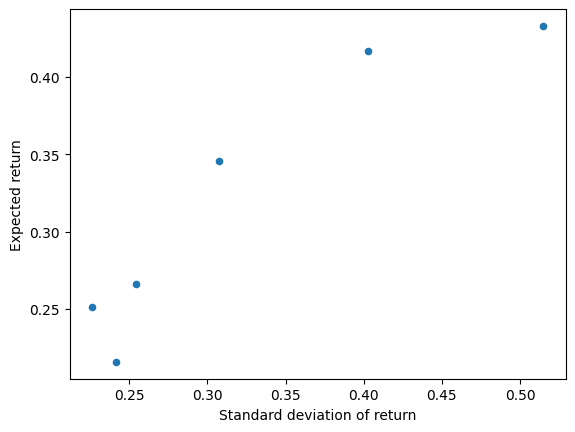

In [4]:
# Plot the stocks in the risk-return space
plt.scatter(arr_cov_matrix.diagonal()**0.5, arr_expected_rets[:,0], s=20)
plt.gca().update(dict(xlabel='Standard deviation of return', ylabel='Expected return'))
plt.show()

## Feasible portfolios and efficient frontier
Consider a portfolio consisting of stocks with positive weights. The first observation is that the feasible set is enlarged. The second observation is that diversification can improve the risk-return profile, as the relationship between weights and standard deviation is non-linear.






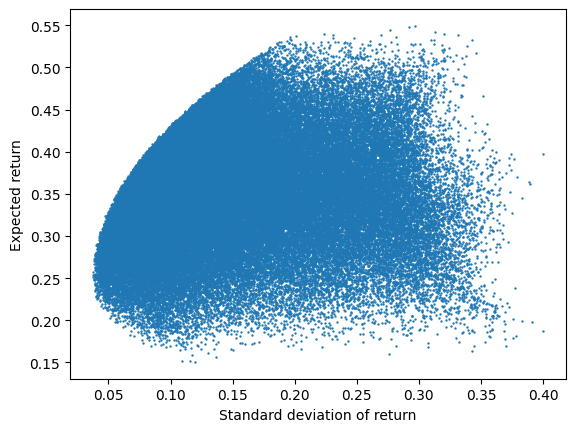

In [5]:
# Sample positive weights
arr_sims = np.random.uniform(0, 1, (num_simulation,N-1))
arr_sims = np.diff(arr_sims, prepend=0, append=1) # sum of the weights will be 1

# Compute return and standard deviation for the sample weights
arr_rets, arr_stds = arr_sims @ arr_expected_rets, []
# stds = np.diag( arr_sims @ arr_cov_matrix @ arr_sims.T ) # large matrix multimplication
for arr_sim in arr_sims:
  arr_stds.append(arr_sim @ arr_cov_matrix @ arr_sim.T)

plt.scatter(arr_stds, arr_rets, s=0.5)
plt.gca().update(dict(xlabel='Standard deviation of return', ylabel='Expected return'))
plt.show()

Consider a portfolio consisting of stocks with real weights. This further expands the feasible set of portfolios. For any expected return above the return of the minimum-variance portfolio, there exists a corresponding minimum-variance portfolio (i.e. efficient frontier). The relationship between these variables can be described by the following formula:

$ \sigma = \frac{AE[r]^2-2BE[r]+C}{D} $

where

$ A = 1' \Sigma^{-1} 1$

$ B = 1' \Sigma^{-1} E[r]$

$ C = E[r]' \Sigma^{-1} 1$

$ D = AC - B^2$

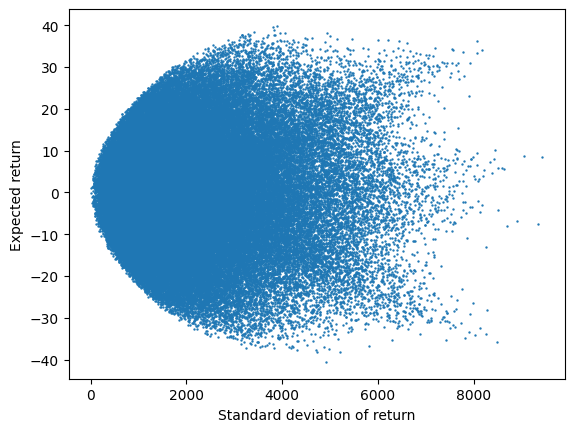

In [6]:
# Sample "real" weights
arr_sims = np.random.uniform(-100, 100, (num_simulation,N-1)) # support can be any interval in reals
arr_sims = np.diff(arr_sims, prepend=0, append=1) # sum of the weights will be 1

# Compute return and standard deviation for the sample weights
arr_rets, arr_stds = arr_sims @ arr_expected_rets, []
# stds = np.diag( arr_sims @ arr_cov_matrix @ arr_sims.T ) # large matrix multimplication
for arr_sim in arr_sims:
  arr_stds.append(arr_sim @ arr_cov_matrix @ arr_sim.T)

plt.scatter(arr_stds, arr_rets, s=0.5)
plt.gca().update(dict(xlabel='Standard deviation of return', ylabel='Expected return'))
plt.show()

## Optimized portfolio
If a risk-free asset is available, the optimized portfolio corresponds to the tangent portfolio whose weight, expected return, and standard deviation of return are as follows:

$ w_T = \frac{\Sigma^{-1} (E[r]-r_f)}{B-Ar_f} $

$ E[r_T] = \frac{C-Br_f}{B-Ar_f} $

$ \sigma(r_T) = \frac{AE[r_T]^2-2BE[r_T]+C}{D} $

In [7]:
# Optimized portfolio is the tangent portfolio
arr_optimized_weights = arr_cov_matrix_inv @ (arr_expected_rets - risk_free_rate*arr_ones) / (B - A*risk_free_rate)
print(f'The optimized weight is: {arr_optimized_weights.flatten()}')

The optimized weight is: [ 0.25852006  0.28273266 -0.09635868  0.26250184  0.17281184  0.11979228]


In [8]:
# The corresponding expected return and the standard deviation of return
opt_expected_ret = (arr_optimized_weights.T @ arr_expected_rets)[0,0]
opt_std = (arr_optimized_weights.T @ arr_cov_matrix @ arr_optimized_weights)[0,0]**0.5
print(f'The expected return is: {opt_expected_ret:.4f}')
print(f'The standard deviation of return is: {opt_std:.4f}')
print(f'The Sharpe ratio is: {(opt_expected_ret-risk_free_rate)/opt_std:.4f}')

The expected return is: 0.3356
The standard deviation of return is: 0.2258
The Sharpe ratio is: 1.3978


In [9]:
# Using formula to find the expected return and the standard deviation of return
opt_expected_ret_1 = ((C - B*risk_free_rate)/(B - A*risk_free_rate))[0,0]
opt_std_1 = ((A*opt_expected_ret**2 - 2*B*opt_expected_ret + C)/D)[0,0]**0.5
print(f'The expected return is: {opt_expected_ret_1:.4f}')
print(f'The standard deviation of return is: {opt_std_1:.4f}')
print(f'The Sharpe ratio is: {(opt_expected_ret-risk_free_rate)/opt_std:.4f}')

The expected return is: 0.3356
The standard deviation of return is: 0.2258
The Sharpe ratio is: 1.3978


## Wrap up the code into a class

In [10]:
class MPT:

  def __init__(self, tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA'],
               start_date = '2010-01-01', end_date = '2020-01-01', risk_free_rate = 0.02):
    self.tickers = tickers
    self.start_date = start_date
    self.end_date = end_date
    self.risk_free_rate = risk_free_rate

  def get_ret_data(self):
    self.df_ret = yf.download(self.tickers, self.start_date, self.end_date)['Adj Close'].pct_change().dropna()

  def optimized_portfolio(self):
    N = len(self.tickers)
    arr_ones = np.array([[1]*N]).T
    arr_weights = np.array([[1/N]*N]).T
    arr_expected_rets = (self.df_ret.mean().values*252)[np.newaxis,:].T # per annum
    arr_cov_matrix = self.df_ret.cov().values*252 # per annum
    arr_cov_matrix_inv = np.linalg.inv(arr_cov_matrix)

    A = arr_ones.T @ arr_cov_matrix_inv @ arr_ones
    B = arr_ones.T @ arr_cov_matrix_inv @ arr_expected_rets
    C = arr_expected_rets.T @ arr_cov_matrix_inv @ arr_expected_rets
    D = A*C - B**2

    arr_optimized_weights = arr_cov_matrix_inv @ (arr_expected_rets - risk_free_rate*arr_ones) / (B - A*self.risk_free_rate)
    opt_expected_ret = ((C - B*risk_free_rate)/(B - A*risk_free_rate))[0,0]
    opt_std = ((A*opt_expected_ret**2 - 2*B*opt_expected_ret + C)/D)[0,0]**0.5

    print(f'The optimized weight is: {arr_optimized_weights.flatten()}')
    print(f'The expected return is: {opt_expected_ret:.4f}')
    print(f'The standard deviation of return is: {opt_std:.4f}')
    print(f'The Sharpe ratio is: {(opt_expected_ret-risk_free_rate)/opt_std:.4f}')

In [11]:
mpt0 = MPT(tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA'])
mpt0.get_ret_data()
mpt0.optimized_portfolio()

[*********************100%***********************]  6 of 6 completed
The optimized weight is: [ 0.25852064  0.2827323  -0.09635862  0.26250173  0.17281176  0.1197922 ]
The expected return is: 0.3356
The standard deviation of return is: 0.2258
The Sharpe ratio is: 1.3978


In [12]:
mpt1 = MPT(tickers = ['BRK-B', 'V', 'UNH', 'WMT', 'JPM', 'XOM'])
mpt1.get_ret_data()
mpt1.optimized_portfolio()

[*********************100%***********************]  6 of 6 completed
The optimized weight is: [ 0.07051659  0.08969826  0.68419431  0.57007723  0.25000153 -0.66448791]
The expected return is: 0.3450
The standard deviation of return is: 0.2351
The Sharpe ratio is: 1.3826


In [13]:
mpt2 = MPT(tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'BRK-B', 'V', 'UNH', 'WMT', 'JPM', 'XOM'])
mpt2.get_ret_data()
mpt2.optimized_portfolio()

[*********************100%***********************]  12 of 12 completed
The optimized weight is: [ 0.19984416  0.19591066 -0.52337717 -0.13721106  0.14354511  0.1767974
  0.14161352  0.10836733  0.56625002  0.4013963   0.24684182 -0.51997809]
The expected return is: 0.4755
The standard deviation of return is: 0.2580
The Sharpe ratio is: 1.7660
